# **PROJECT :HATE SPEECH DETECTION** #



PROBLEM STATEMENT:Hate speech refers to any form of verbal, written, or behavioral communication that attacks or uses derogatory or discriminatory language against individuals or groups based on characteristics such as religion, ethnicity, nationality, race, gender, or other identity factors. In this project, we will build a hate speech detection model using machine learning techniques in Python.

Hate speech detection is essentially a sentiment classification task. To train a model capable of identifying hate speech from text, we will use a dataset typically employed for sentiment analysis. For this specific task, we will utilize Twitter data to detect tweets that contain hate speech.

#Part 1: Import Twitter Hate Speech Data and Analyze#

In [1]:
import warnings

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import re
import nltk
import string
from nltk.text import Text

plt.style.use('fivethirtyeight')
warnings.filterwarnings("ignore")

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
os.chdir("/content/drive/MyDrive")
df = pd.read_csv("train_E6oV3lV.csv")

In [4]:
df.head()

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


## INFORMATIONS ABOUT THE DATA##

In [5]:
print(f'Number of Observations: {df.shape[0]}')
print(f'Number of Features: {df.shape[1]}')

Number of Observations: 31962
Number of Features: 3


In [6]:
df.columns

Index(['id', 'label', 'tweet'], dtype='object')

In [7]:
df.dtypes

,0
id,int64
label,int64
tweet,object


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31962 entries, 0 to 31961
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      31962 non-null  int64 
 1   label   31962 non-null  int64 
 2   tweet   31962 non-null  object
dtypes: int64(2), object(1)
memory usage: 749.2+ KB


In [9]:
df.size

95886

### Checking for null values###

In [10]:
df.isnull().sum()

,0
id,0
label,0
tweet,0


###Extracting the Target Attribute for Each Class and Visualize###

Hate Speech: 2242
Free Speech: 29720


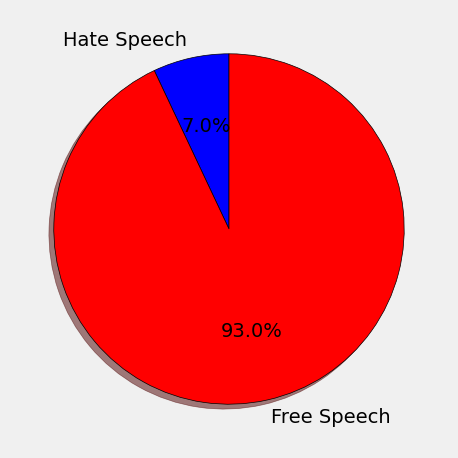

In [11]:
# Count the number of instances for each class in the 'label' column
hate_speech_count = df[df['label'] == 1].shape[0]
free_speech_count = df[df['label'] == 0].shape[0]
print('Hate Speech:', hate_speech_count)
print('Free Speech:', free_speech_count)

# Prepare data for pie chart visualization
speech_counts = [hate_speech_count, free_speech_count]
labels = ["Hate Speech", "Free Speech"]

# Create a pie chart to visualize the distribution of classes
plt.pie(speech_counts, labels=labels, shadow=True, wedgeprops={'edgecolor': 'black'},
        autopct='%1.1f%%', startangle=90, colors=['blue', 'red'])

plt.tight_layout()
plt.show()

#Part 2: Data Preprocessing#

In this section, we focused on data preprocessing. We began by cleaning the text using Regular Expressions, followed by tokenizing the sentences into individual words. Next, we removed stopwords such as "the", "a", and "at", and applied stemming to reduce words to their root forms. Afterward, we used the TF-IDF model for feature extraction, selecting the 2,000 most frequent words from the corpus. Finally, we split the dataset into training and testing sets, with an 80% training and 20% testing ratio.

CLEANING THE DATA

In [12]:
import string
import re

# Convert text to lowercase
def convert_to_lowercase(text):
    return text.lower()

# Strip punctuation from text
def strip_punctuation(text):
    return text.translate(str.maketrans('', '', string.punctuation))

# Remove URLs from text
def eliminate_urls(text):
    return re.sub(r'http\S+|www\S+', '', text)

# Remove Twitter handles (e.g., @username) from text
def eliminate_handles(text):
    return re.sub(r'@\w+', '', text)

# Remove special characters, keeping only alphanumeric characters
def clean_special_characters(text):
    return " ".join(word for word in text.split() if word.isalnum())

# Apply text processing functions to the 'tweet' column of the DataFrame
df['tweet'] = df['tweet'].apply(convert_to_lowercase)
df['tweet'] = df['tweet'].apply(strip_punctuation)
df['tweet'] = df['tweet'].apply(eliminate_urls)
df['tweet'] = df['tweet'].apply(eliminate_handles)
df['tweet'] = df['tweet'].apply(clean_special_characters)



###TOKENIZING###

In [13]:
from nltk.tokenize import sent_tokenize, word_tokenize
import nltk

# Download the 'punkt' tokenizer models if not already available
nltk.download('punkt')

# Define a function that takes in a string and tokenizes it into words
def tokenize(text):
    tokens = word_tokenize(text)
    return tokens

# Apply the 'tokenize' function to each element in the 'tweet' column of the DataFrame
df['tweet'] = df['tweet'].apply(tokenize)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


###REMOVING STOPWORDS###

In [14]:
from nltk.corpus import stopwords
import nltk

# Download the 'stopwords' dataset if not already present
nltk.download('stopwords')

# Define a function to remove stopwords from the given text
def remove_stop(text):
    filtered_text = [word for word in text if word not in stopwords.words('english')]
    return filtered_text

# Apply the 'remove_stop' function to each entry in the 'tweet' column of the DataFrame
df['tweet'] = df['tweet'].apply(remove_stop)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


###LEMMATIZATION-REDUCING WORDS TO THEIR BASE FORM###

In [15]:
from nltk.stem import WordNetLemmatizer
import nltk

# Download the 'wordnet' dataset if it's not already present
nltk.download('wordnet')

# Define a function to lemmatize the words in the given text
def lemmatize_text(text):
    lemmatizer = WordNetLemmatizer()
    lemmatized_text = [lemmatizer.lemmatize(word) for word in text]
    return lemmatized_text

# Apply the 'lemmatize_text' function to each row in the 'tweet' column of the DataFrame
df['tweet'] = df['tweet'].apply(lemmatize_text)


[nltk_data] Downloading package wordnet to /root/nltk_data...


###WORD CLOUD###

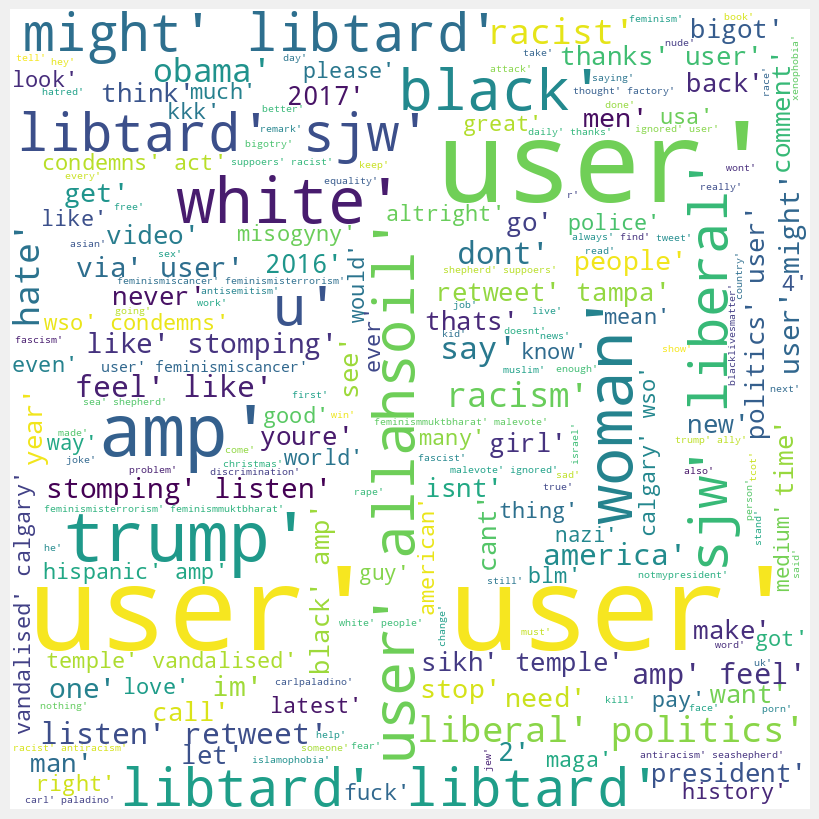

In [16]:
from wordcloud import WordCloud, STOPWORDS

# Filter the DataFrame for rows labeled as hate speech
hate_speech = df[df['label'] == 1]
comment_words = ''
stopwords = set(STOPWORDS)

# Iterate through each tweet in the filtered hate speech data
for val in hate_speech['tweet']:

    # Convert the tweet to a string if it's not already one
    val = str(val)

    # Split the tweet into individual words (tokens)
    tokens = val.split()

    # Convert each word to lowercase
    tokens = [word.lower() for word in tokens]

    # Combine the tokens back into a single string and append to comment_words
    comment_words += " ".join(tokens) + " "

# Generate a WordCloud using the collected hate speech words
wordcloud = WordCloud(width=800, height=800,
                      background_color='white',
                      stopwords=stopwords,
                      min_font_size=10).generate(comment_words)

# Display the generated WordCloud
plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(wordcloud)
plt.axis("off")  # Hide the axes
plt.tight_layout(pad=0)

plt.show()


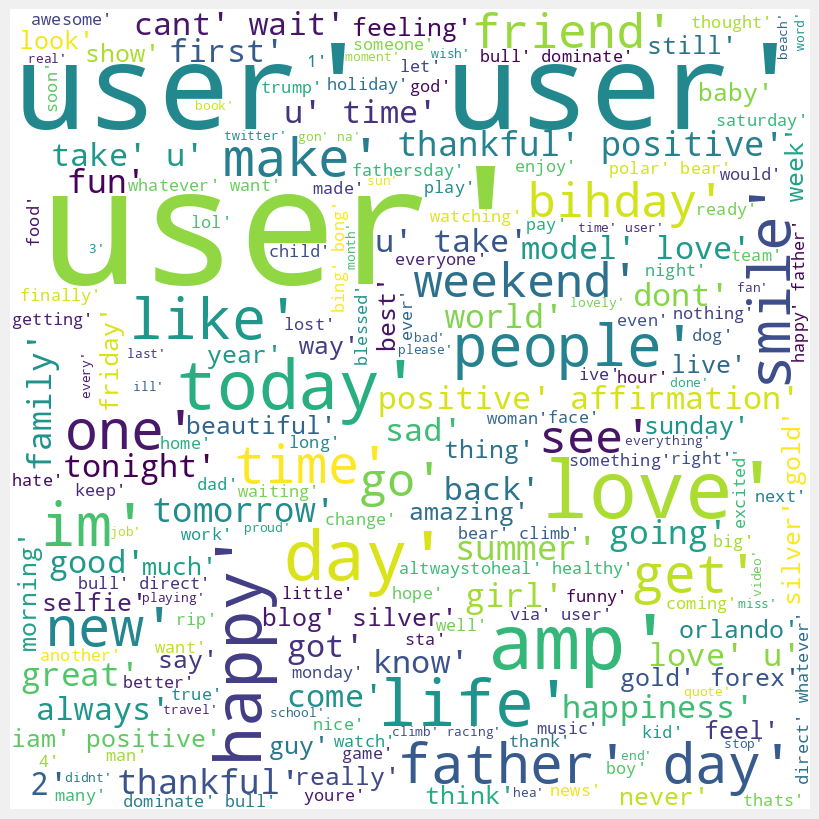

In [17]:
from wordcloud import WordCloud, STOPWORDS

# Filter for tweets labeled as free speech
free_speech_tweets = df[df['label'] == 0]

# Initialize an empty string for combining all tweet text
combined_words = ''
stopwords_set = STOPWORDS

# Process each tweet in the free speech dataset
for tweet in free_speech_tweets['tweet']:

    # Ensure the tweet is a string and split into individual words
    words = str(tweet).split()

    # Convert all words to lowercase and append to the combined string
    combined_words += " ".join([word.lower() for word in words]) + " "

# Generate the WordCloud with the combined free speech words
wordcloud = WordCloud(width=800, height=800,
                      background_color='white',
                      stopwords=stopwords_set,
                      min_font_size=10).generate(combined_words)

# Display the WordCloud using matplotlib
plt.figure(figsize=(8, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")  # Hide axes
plt.tight_layout(pad=0)

plt.show()


In [18]:
# Import the TF-IDF vectorization tool from sklearn
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize the TF-IDF vectorizer, limiting it to the top 2000 most common words
tfidf = TfidfVectorizer(max_features=2000)

# Convert tokenized lists in the 'tweet' column back to strings
converted_tweets = [' '.join(tokens) for tokens in df['tweet']]

# Update the 'tweet' column with the joined strings
df['tweet'] = converted_tweets

# Use the TF-IDF model to fit and transform the tweet text
corpus_data = df['tweet']
tfidf_features = tfidf.fit_transform(corpus_data).toarray()

# Display the dimensions of the resulting TF-IDF matrix
tfidf_features.shape


(31962, 2000)